In [1]:
import pandas as pd
import numpy as np
import altair as alt
from altair.expr import datum

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
fitd = dict()
freqd = dict()
for bfa_name in ['dBFA2', 'hBFA1', 'hBFA2']:
    fitd[bfa_name] = pd.read_csv('../Fitness_data/'+bfa_name+'_all_fitness_new2.csv')
    fitd[bfa_name]['GC'] = fitd[bfa_name]['Barcode'].apply(lambda b: len([i for i in b if i in ['G', 'C']])/len(b))
    freqd[bfa_name] = pd.read_csv('../Fitness_data/'+bfa_name+'_all_freqs_tidy_new2.csv')
    

In [3]:
# define the theme by returning the dictionary of configurations
def my_style():
    return {
        'config': {
            'view': {
                'stroke': 'transparent', # despine!!!!
                'continuousWidth': 400, 
                'continuousHeight': 300
            },
            'axis': {
                'grid':False, 
                'labelFontSize':16, 
                'titleFontSize':16
            },
            'title': {
                'fontSize': 18
            },
            'mark': {
                'color': 'black'
            }
        }
    }

# register the custom theme under a chosen name
alt.themes.register('my_style', my_style)
alt.themes.enable('my_style')
alt.data_transformers.disable_max_rows();

In [8]:
bfa_reps = {'hBFA1': ['R1', 'R2'], 'hBFA2': ['R1', 'R2', 'R3'], 'dBFA2': ['R1', 'R2', 'R3']}

def scatter(df, c1, c2):
    td = df[(df[c1].notnull()) & (df[c2].notnull())]
    
    xr = (np.min(td[c1]), np.max(td[c1]))
    yr = (np.min(td[c2]), np.max(td[c2]))
    if xr[1]-xr[0] > yr[1]-yr[0]:
        use_range = yr
    else:
        use_range = xr
        
    xy_line = alt.Chart(pd.DataFrame({'x': use_range, 'y': use_range})).mark_line(opacity=0.2).encode(x='x', y='y')
    
    scatter = alt.Chart().mark_circle().encode(
        x=c1, y=c2,
        color='Home_Environment',
        stroke=alt.value('black'),
        strokeOpacity=alt.condition((bc_hover | bc_click), alt.value(1), alt.value(0)),
        strokeWidth=alt.condition(bc_click, alt.value(8), alt.value(4)),
        tooltip=['GC', 'Barcode']
    ).add_selection(bc_hover, bc_click)
    
    return alt.layer(xy_line, scatter).properties(width=150, height=150)

def big_scatter(bfa_name, env, fitd_use, freqd_use):
    td = fitd_use[bfa_name][(fitd_use[bfa_name]['Test_Environment']==env) & (~fitd_use[bfa_name]['Home_Environment'].isin(['not_read', 'none']))]
    home_envs = sorted(set(td['Home_Environment']))
    # Env selector
    env_cols = alt.Color('Home_Environment', scale=alt.Scale(domain=home_envs), legend=None)
    env_types = pd.DataFrame({'Home_Environment': home_envs})
    env_select = alt.selection_multi(fields=['Home_Environment'], init=[{'Home_Environment': e} for e in home_envs])
    env_selector = (alt.Chart(env_types).mark_rect()
                       .encode(y=alt.Y('Home_Environment', axis=alt.Axis(title=None)), color=env_cols, opacity=alt.condition(env_select, alt.value(1), alt.value(0.2)))
                       .properties(title={'text': 'Home Env.', 'dx': -20})
                       .add_selection(env_select))
    
    s_graphs = alt.hconcat()
    rc = 0
    for ry in bfa_reps[bfa_name]:
        rc += 1
        for rx in bfa_reps[bfa_name][rc:]:
            s_graphs = alt.hconcat(s_graphs, scatter(td, 's_'+rx, 's_'+ry), data=td)
        
    fgs = alt.hconcat()
    columns_needed = ['Barcode', 'Home_Environment', 'Time', 'Clipped_Log10(Freq)']
    tdf = freqd_use[bfa_name][(freqd_use[bfa_name]['Test_Environment']==env) & (~freqd_use[bfa_name]['Home_Environment'].isin(['not_read', 'none'])) & (freqd_use[bfa_name]['Clipped_Log10(Freq)'].notnull())]
    for rep in bfa_reps[bfa_name]:
        tmp_graph = alt.Chart(tdf[(tdf['Putative_Neutral']) & (tdf['Replicate']==rep)][columns_needed]).mark_line(strokeWidth=0.5).encode(
            x='Time', 
            y='Clipped_Log10(Freq)',
            detail='Barcode',
            color=alt.value('#888888')
        )
        tmp_top_graph = alt.Chart(tdf[tdf['Replicate']==rep][columns_needed]).mark_line(strokeWidth=4).encode(
            x='Time', 
            y='Clipped_Log10(Freq)',
            detail='Barcode',
            color=env_cols
        ).transform_filter(bc_click)
        fgs = alt.hconcat(fgs, alt.layer(tmp_graph, tmp_top_graph).properties(width=150, height=150))

    return alt.hconcat(alt.vconcat(s_graphs.transform_filter(env_select), fgs), env_selector)
                

bc_hover = alt.selection_single(on='mouseover', fields=['Barcode'], empty='none')
bc_click = alt.selection_single(on='click', fields=['Barcode'], empty='none')
big_scatter('hBFA2', 'FLC4', fitd, freqd)

alt.HConcatChart(...)

# Plotting s correlations between replicates

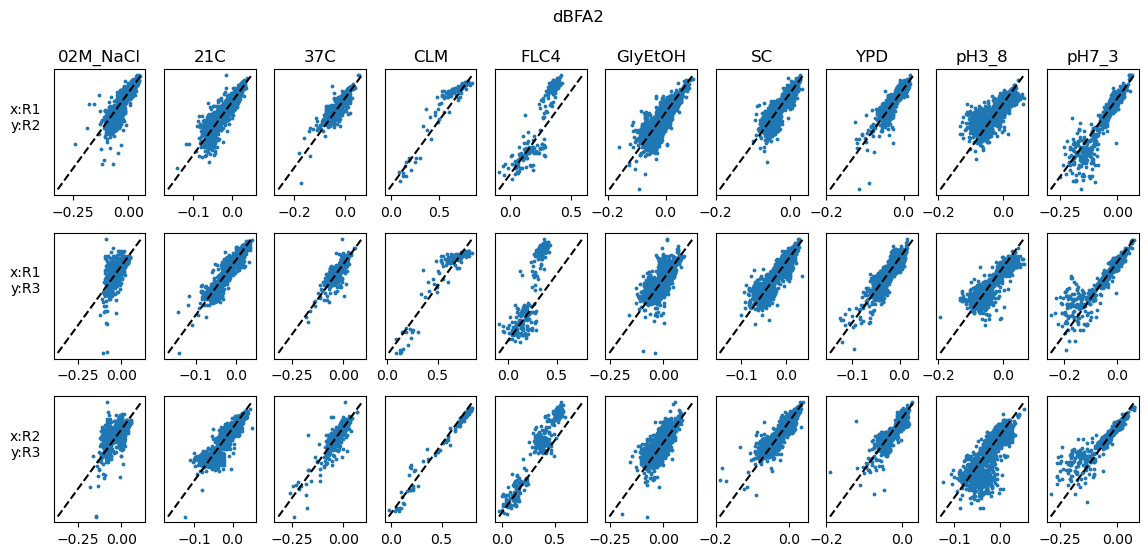

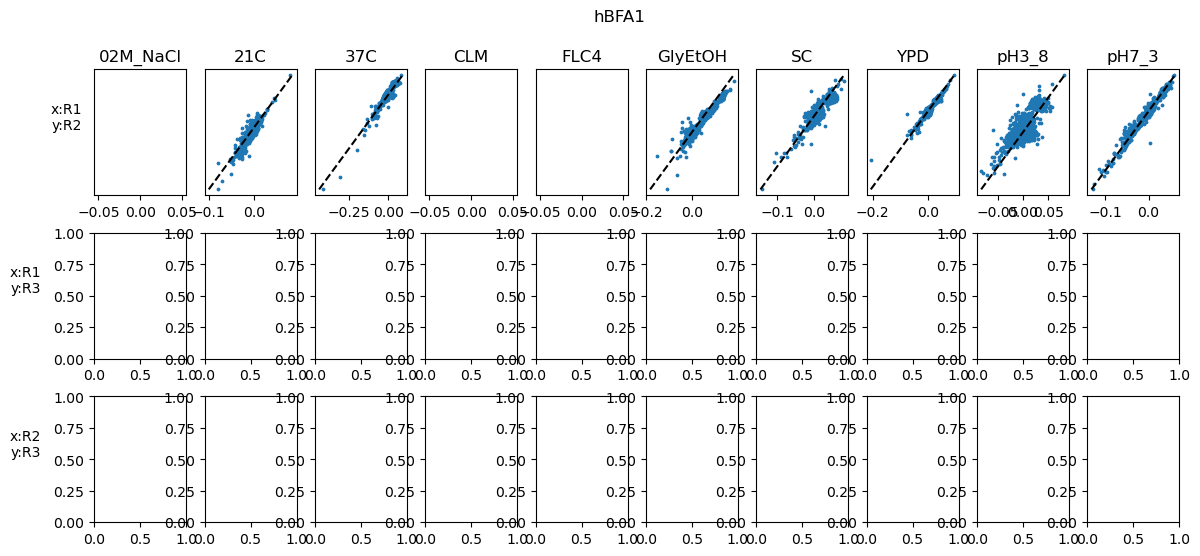

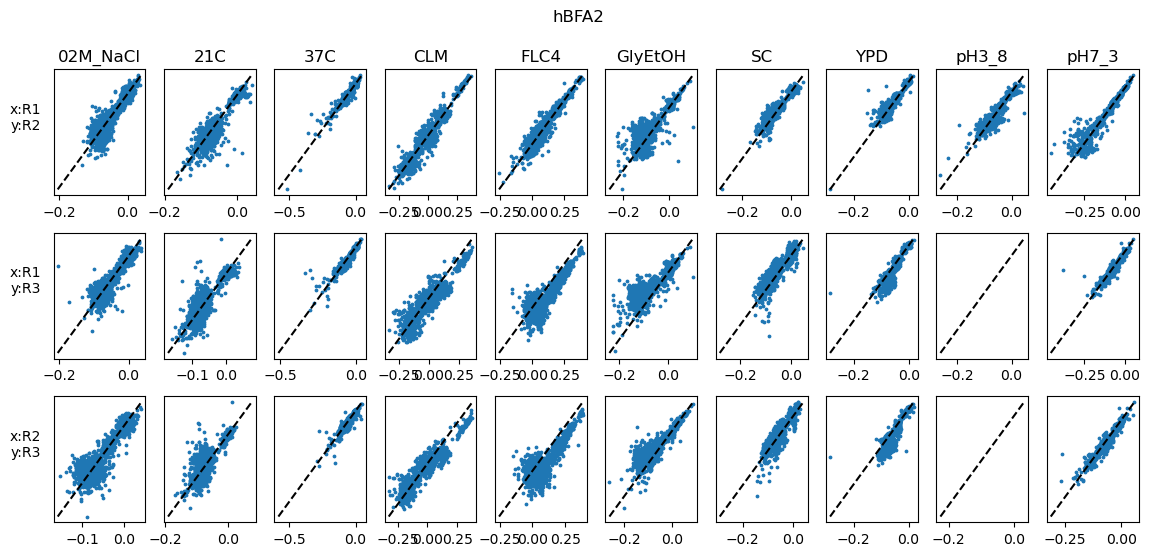

In [12]:
reps = ['R1', 'R2', 'R3']
for bfa_name in fitd:
    envs = sorted(set(fitd[bfa_name]['Test_Environment']))
    fig, subps = plt.subplots(3, len(envs), figsize=(14, 6), dpi=100)
    plt.subplots_adjust(hspace=0.3)
    ec = -1
    for env in envs:
        tmp = fitd[bfa_name][fitd[bfa_name]['Test_Environment']==env]
        ec += 1
        rc = -1
        for rep1 in reps:
            for rep2 in reps[reps.index(rep1)+1:]:
                rc += 1
                if 's_'+rep1 in tmp and 's_'+rep2 in tmp:
                    extent = [min(list(tmp['s_'+rep1]) + list(tmp['s_'+rep2])), max(list(tmp['s_'+rep1]) + list(tmp['s_'+rep2]))]
                    subps[rc][ec].plot(extent, extent, linestyle='dashed', c='k')
                    subps[rc][ec].scatter(tmp['s_'+rep1], tmp['s_'+rep2], s=3)
                    subps[rc][ec].set_yticks([])
                    
                if rc == 0:
                    subps[rc][ec].set_title(env)
                if ec == 0:
                    subps[rc][ec].set_ylabel('x:'+rep1+'\ny:'+rep2, rotation='horizontal', labelpad=20)
    fig.suptitle(bfa_name)
                    
                    
    #fig.savefig('../Fitness_data/s_correlations/' + bfa_name + '-' + env + '_unweighted_ave.png')
    #pl.close("all")   

## Looks good enough to me!

# Next up: 
### classify mutations as neutral or not, while also rescaling fitness for diploids and haploids
### classify autodiploid cluster?
### show that bcs with the same mutations have similar fitness profiles
### make mutation-based dataset (take median fitness of barcodes when necessary

In [47]:
for i in fitd:
    for j in fitd:
        print(i, j, len(set(fitd[i]['Barcode']).intersection(set(fitd[j]['Barcode']))))

dBFA2 dBFA2 4125
dBFA2 hBFA1 0
dBFA2 hBFA2 320
hBFA1 dBFA2 0
hBFA1 hBFA1 1836
hBFA1 hBFA2 81
hBFA2 dBFA2 320
hBFA2 hBFA1 81
hBFA2 hBFA2 2408


In [43]:
# Scaling haploid fitnesses measured in hBFA correctly
# the reference class used in hBFA2 was CLM_2N, 
# so I will use the median YPD_alpha fitness in hBFA 2 to scale haploid fitnesses

haploid_disadvantage = dict()
td = fitd['hBFA2']
for te in set(td['Test_Environment']):
    haploid_disadvantage[te] = np.nanmedian(td[(td['Home_Environment']=='YPD_alpha') & (td['Test_Environment']==te)]['s_iva'])
    
haploid_disadvantage

{'FLC4': 0.03329606920196215,
 'CLM': -0.18506336401883616,
 'YPD': -0.08230333524589573,
 '37C': -0.08201888964175641,
 '02M_NaCl': -0.0801701698980079,
 'pH3_8': -0.07095197831932211,
 '21C': -0.0822433613679716,
 'SC': -0.07998328491053748,
 'pH7_3': -0.07265862040749718,
 'GlyEtOH': -0.09900624746955189}

In [62]:
def fix_fitness(row):
    # if this is a haploid strain in hBFA2, adjust the fitness to be scaled to the haploid ancestor
    if row['BFA']=='hBFA2' and '_alpha' in row['Home_Environment']:
        return row['s_iva'] - haploid_disadvantage[row['Test_Environment']]
    else:
        return row['s_iva']
    
fd['s'] = fd.apply(fix_fitness, axis=1)
fd

BFA                                            Barcode  \
0      dBFA2  TTGTAAATCGCTAACGAATTTGGGCATCATGAAACACATTCATCGT...   
1      dBFA2  CATAAAATCAATAAATGTGTTCTGCGTCCGAACGCAGTTTCGTGTT...   
2      dBFA2  TTGAGAACACGGAACGGTATTTAGTCCACTTAACTTGGTTAACGTT...   
3      dBFA2  ACGTAAACCAAGAATTTATTTCCGATTTATTAACTTCATTAGTAAT...   
4      dBFA2  TCGCGAACAGGAAAGATGATTGCGACGTGTCAATCGATTTTTTTGT...   
...      ...                                                ...   
24075  hBFA2  AACACAACAAGTAAATAGGTTGAATTTCCTAAACGGAATTTTTTCT...   
24076  hBFA2  CTTGAAATCCATAAAAGTATTATGGCTGCTAAAGTGTATTTTTCCT...   
24077  hBFA2  AGAAGAATACGAAACTGGATTGTGCCGCAATAATGCTCTTGACTTT...   
24078  hBFA2  GCTCAAAGTTGAAAAGTATTTGCCCATGCTAAAGTGTATTTTTCCT...   
24079  hBFA2  AGTATAATTAACAAGTGGGTTTCACAACCTGAAAAGTCTTCAATTT...   

      Home_Environment  Putative_Neutral Test_Environment     s_iva         s  
0               37C_2N             False              YPD  0.023828  0.023828  
1               21C_2N             False              YPD -0.008886 -0.008886  
2               21C_2N             False              YPD  0.021888  0.021888  
3               CLM_2N             False              YPD -0.012283 -0.012283  
4          02M_NaCl_2N             False              YPD  0.000040  0.000040  
...                ...               ...              ...       ...       ...  
24075       FLC4_alpha             False         02M_NaCl       NaN       NaN  
24076      pH7_3_alpha             False         02M_NaCl       NaN       NaN  
24077        21C_alpha             False         02M_NaCl       NaN       NaN  
24078      pH7_3_alpha             False         02M_NaCl       NaN       NaN  
24079        21C_alpha             False         02M_NaCl       NaN       NaN  

[83690 rows x 7 columns]

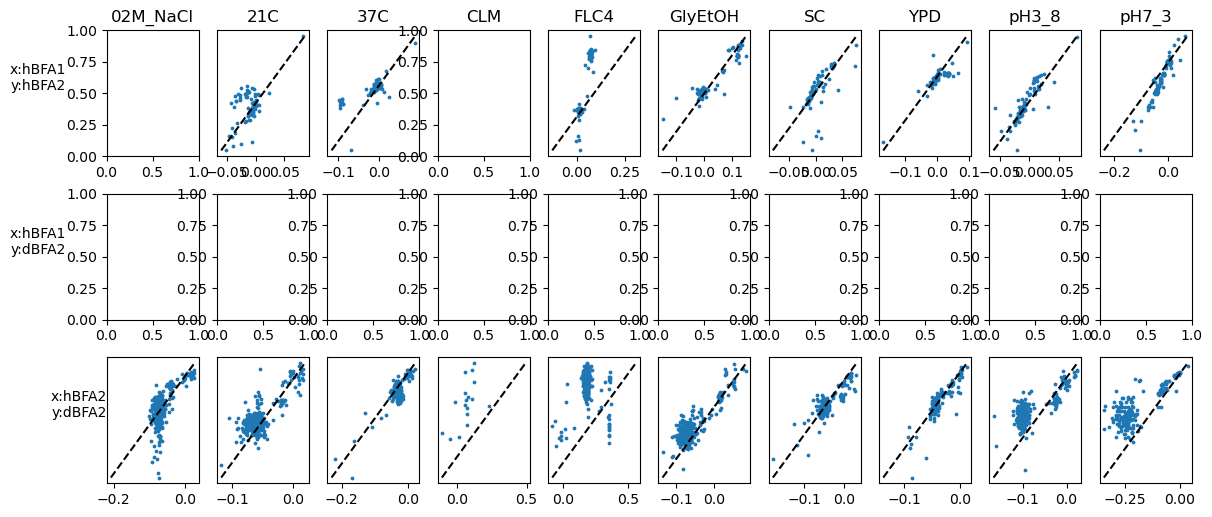

In [63]:
bfas = ['hBFA1', 'hBFA2', 'dBFA2']
envs = sorted(set(fitd['dBFA2']['Test_Environment']))
fig, subps = plt.subplots(3, len(envs), figsize=(14, 6), dpi=100)
plt.subplots_adjust(hspace=0.3)
ec = -1
for env in envs:
    td = fd[fd['Test_Environment']==env]
    ec += 1
    rc = -1
    for bfa1 in bfas:
        for bfa2 in bfas[bfas.index(bfa1)+1:]:
            bcs1 = {i[0]: i[1] for i in np.array(td[td['BFA']==bfa1][['Barcode', 's']]) if pd.notnull(i[1])}
            bcs2 = {i[0]: i[1] for i in np.array(td[td['BFA']==bfa2][['Barcode', 's']]) if pd.notnull(i[1])}
            bc_overlap = [bc for bc in bcs1 if bc in bcs2]
            x = [bcs1[bc] for bc in bc_overlap]
            y = [bcs2[bc] for bc in bc_overlap]
            rc += 1
            if len(x) > 0:
                extent = [min(x+y), max(x+y)]
                subps[rc][ec].plot(extent, extent, linestyle='dashed', c='k')
                subps[rc][ec].scatter(x, y, s=3)
                subps[rc][ec].set_yticks([])

            if rc == 0:
                subps[rc][ec].set_title(env)
            if ec == 0:
                subps[rc][ec].set_ylabel('x:'+bfa1+'\ny:'+bfa2, rotation='horizontal', labelpad=20)

In [66]:
for bfa1 in bfas:
    for bfa2 in bfas[bfas.index(bfa1)+1:]:
        bcs1 = set(fd[fd['BFA']==bfa1]['Barcode'])
        bcs2 = set(fd[fd['BFA']==bfa2]['Barcode'])
        print(bfa1, bfa2)
        print(fd[fd['Barcode'].isin(bcs1.intersection(bcs2))][['Barcode', 'Home_Environment']].drop_duplicates()['Home_Environment'].value_counts())

hBFA1 hBFA2
CLM_alpha        39
GlyEtOH_alpha    27
FLC4_alpha       10
21C_alpha         3
YPD_alpha         1
pH7_3_alpha       1
Name: Home_Environment, dtype: int64
hBFA1 dBFA2
Series([], Name: Home_Environment, dtype: int64)
hBFA2 dBFA2
FLC4_2N       302
GlyEtOH_2N     18
Name: Home_Environment, dtype: int64


In [27]:
r = fitd['hBFA2'][fitd['hBFA2']['Test_Environment']=='pH3_8'].iloc[0]
errors = [r[i] for i in r.keys() if '_error' in i]
len([i for i in errors if i in [0, np.nan]])==len(errors)

False

In [33]:
if errors[0]:
    print('ah')

ah


In [34]:
pd.isnull(errors[0])

True